Created on December 20th 2020 by Patrick Rotzetter

https://www.linkedin.com/in/rotzetter/

# Small experiment of document mining with various techniques Part 1

In the first part, we will be using spacy for tokenization, parsing and named entity recognition. We will then look at some simple statistics based on spacy results.

In [ ]:
#check python version and path
import sys
sys.executable

'/usr/local/bin/python'

In [ ]:
#import main libraries
import numpy as np
import PyPDF2
import spacy
import pandas as pd
import re
from pptx import Presentation
import pdftotext
import texthero as hero

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
#  validate spacy language models just in case, this command does not work on Mac ARM systems unless you have installed the brew workaround and reinstalled python
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.3.5) ======================
ℹ spaCy installation: /opt/venv/lib/python3.7/site-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-lg   en_core_web_lg   2.3.1   ✔



In [ ]:
# function to read PDF files using PYPdf2
def readPdfFilePY(filename):
    text=""
    read_pdf = PyPDF2.PdfFileReader(filename,'rb')   
    for i in range(read_pdf.getNumPages()):
        page = read_pdf.getPage(i)
        txt=page.extractText()
        text=text+txt
    return text


In [ ]:
# function to read PDF files using pdftotext
def readPdfFile(filename):
    text=""
    with open(filename, "rb") as f:
        pdf = pdftotext.PDF(f)
        for page in pdf:
            text=text+page
    return text

In [ ]:
# function to read PPT files
def readPPTFile(filename):
    text=""  
    prs = Presentation(filename)
    for slide in prs.slides:
        for shape in slide.shapes:
            if hasattr(shape, "text"):
                text=text+shape.text
    text=remove_special_characters(text)
    return text

In [ ]:
#path of first input test file
path='./sampledocs/'
docFile = path+'Technology-and-innovation-in-the-insurance-sector.pdf' 

In [ ]:
#read the PDF File
 
textFromPdf=readPdfFile(docFile)
len(textFromPdf)

126362

In [ ]:
# print the start of file to check we have read it correctly
print(textFromPdf[0:100])

Technology and
innovation in the
insurance sector
TECHNOLOGY AND INNOVATION
  IN THE INSURANCE SECTO


In [ ]:
#path of second input file
docFile = path+'Digital-disruption-in-Insurance.pdf' 

In [ ]:
#read the second PDF file   
textFromPdf2=readPdfFile(docFile)
len(textFromPdf2)

449846

In [ ]:
# print the file to check we have read it correctly
print(textFromPdf2[0:100])

Digital disruption
in insurance:
Cutting through
the noise
 Contents
 Preface								               


## Process files with spacy and calculate their similarity

In [ ]:
# load spacy with large English model
# nlp = spacy.load("en-core-web-lg") -- was working on Windows, but now on a Mac
import en_core_web_lg
nlp = en_core_web_lg.load()

In [ ]:
# let us process the 2 files using spacy pipeline
docpdf1=nlp(textFromPdf)
docpdf2=nlp(textFromPdf2)

In [ ]:
# let us check the document vector shape
docpdf1.vector.shape

(300,)

In [ ]:
# calculate document similarity with spacy function
docpdf1.similarity(docpdf2)

0.9921302281086746

In [ ]:
# document similarity can also be calculated by multiplying the document vectors. we will use this later on
np.dot(docpdf1.vector,docpdf2.vector)

6.81796

## Process all directory files with spacy

In [ ]:
# helper function to process documents in an apply function and return the nlp object
def processDoc(doc):
    return nlp(doc)

In [ ]:
# let us scan the full directory, read PDF and PPT documents, clean them and process them with spacy

docName=[]
docType=[]
docText=[]
docNLP=[]
import glob
list_of_files = glob.glob(path+'*.pdf')           # create the list of file
fileNames=[]
for file_name in list_of_files:
    fileText=readPdfFile(file_name)
    docName.append(file_name)
    docType.append('pdf')
    docText.append(fileText)
list_of_files = glob.glob(path+'*.pptx')           # create the list of file
for file_name in list_of_files:
    fileText=readPPTFile(file_name)
    docName.append(file_name)
    docType.append('ppt')
    docText.append(fileText)
fullDocs = pd.DataFrame({'Name':docName,'Type':docType,'Text':docText})
fullDocs['cleanText']=hero.clean(fullDocs['Text'])
fullDocs['NLP']=fullDocs['cleanText'].apply(processDoc)

In [ ]:
 print ("Average length of text:" + str((np.mean(fullDocs['Text'].str.len()))))
 print ("Min length of text:" + str((np.min(fullDocs['Text'].str.len()))))
 print ("Max length of text:" + str((np.max(fullDocs['Text'].str.len()))))

Average length of text:193429.625
Min length of text:17792
Max length of text:449846


In [ ]:
fullDocs['text_word_count'] = fullDocs['Text'].apply(lambda x: len(x.strip().split()))  # word count
fullDocs['text_unique_words']=fullDocs['Text'].apply(lambda x:len(set(str(x).split())))  # number of unique words
fullDocs.head()

,Name,Type,Text,cleanText,NLP,text_word_count,text_unique_words
0,./sampledocs/Module-1-Lecture-Slides.pdf,pdf,"Application of AI, Insurtech and Real Estate\n...",application ai insurtech real estate technolog...,"(application, ai, insurtech, real, estate, tec...",3732,1509
1,./sampledocs/fra-2020-artificial-intelligence_...,pdf,GETTING THE\nFUTURE RIGHT\n―\nARTIFICIAL\nINTE...,getting future right -- artificial intelligenc...,"(getting, future, right, --, artificial, intel...",49776,8464
2,./sampledocs/EPAM_Streamlining_the_Auto_Claims...,pdf,WHITE PAPER\nStreamlining ...,white paper streamlining automotive claims pro...,"(white, paper, streamlining, automotive, claim...",2502,1006
3,./sampledocs/Issues_Paper_on_Increasing_Digita...,pdf,Issues Paper on Increasing Digitalisatio...,issues paper increasing digitalisation insuran...,"(issues, paper, increasing, digitalisation, in...",15393,3684
4,./sampledocs/sigma1_2020_en.pdf,pdf,No 1 /2020\nData-...,data driven insurance executive summary battle...,"(data, driven, insurance, executive, summary, ...",18846,5317


In [ ]:
fullDocs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Name               8 non-null      object
 1   Type               8 non-null      object
 2   Text               8 non-null      object
 3   cleanText          8 non-null      object
 4   NLP                8 non-null      object
 5   text_word_count    8 non-null      int64 
 6   text_unique_words  8 non-null      int64 
dtypes: int64(2), object(5)
memory usage: 576.0+ bytes


In [ ]:
fullDocs.describe()

,text_word_count,text_unique_words
count,8.000000,8.00000
mean,19506.375000,4453.37500
std,15720.028344,2531.70394
min,2502.000000,1006.00000
25%,11814.000000,3140.25000
50%,16078.000000,4290.00000
75%,22767.250000,5754.50000
max,49776.000000,8464.00000


## Word count and most common words and nouns

In [ ]:
# let us look most used words for each part of speech
from collections import defaultdict, Counter

posCounts = defaultdict(Counter)

for doc in fullDocs.NLP:
    for token in doc:
        posCounts[token.pos][token.orth] += 1

for pos_id, counts in sorted(posCounts.items()):
    pos = doc.vocab.strings[pos_id]
    for orth_id, count in counts.most_common(1):
        print(pos, count, doc.vocab.strings[orth_id])

ADJ 547 digital
ADP 134 across
ADV 421 also
AUX 14 get
CCONJ 33 yet
DET 72 another
INTJ 20 ai
NOUN 1376 data
NUM 208 one
PART 471 '
PRON 36 us
PROPN 533 ai
PUNCT 867 "
SCONJ 73 whether
SYM 3 x
VERB 376 based
X 30 ml


In [ ]:
# add some common words to stop wordds that may not add much context
from spacy.lang.en.stop_words import STOP_WORDS
customStopWords = [
    'insurance','insurer','customer','technology','datum']

for w in customStopWords:
    if w not in STOP_WORDS:
        STOP_WORDS.add(w)

In [ ]:
# get most common nouns
from collections import defaultdict, Counter
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
# all tokens that arent stop words or punctuations
words=[]
for doc in fullDocs.NLP:
    words += [token.lemma_ for token in doc if token.pos==NOUN and (not token.lemma_ in STOP_WORDS)] 
# five most common tokens
wordFreq = Counter(words)
commonWords = wordFreq.most_common(20)
print(commonWords)

[('risk', 503), ('right', 492), ('system', 485), ('business', 432), ('product', 399), ('example', 390), ('company', 366), ('use', 344), ('consumer', 343), ('data', 335), ('model', 332), ('service', 330), ('information', 310), ('case', 290), ('decision', 289), ('process', 281), ('protection', 269), ('value', 259), ('impact', 259), ('claim', 250)]


<AxesSubplot:>

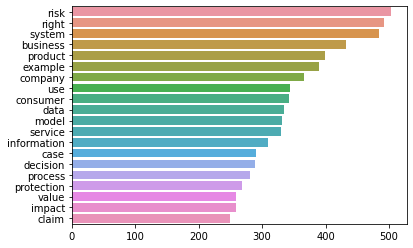

In [ ]:
import seaborn as sns


x, y= [], []
for word,count in commonWords[:20]:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [ ]:
# get most common proper nouns
from collections import defaultdict, Counter
from spacy.symbols import nsubj, VERB, dobj, NOUN, root, xcomp, PROPN, NUM,SYM
# all tokens that arent stop words or punctuations
words=[]
for doc in fullDocs.NLP:
    
    words += [token.lemma_ for token in doc if token.pos==PROPN and (not token.lemma_ in STOP_WORDS)\
             and (len(token)>1)] 


# five most common tokens
wordFreq = Counter(words)
commonWords = wordFreq.most_common(20)
print(commonWords)

[('ai', 533), ('eu', 267), ('insurtech', 173), ('european', 164), ('mi', 163), ('data', 160), ('swiss', 148), ('digital', 102), ('sigma', 98), ('institute', 91), ('council', 74), ('committee', 74), ('fra', 68), ('gdpr', 67), ('mckinsey', 67), ('protection', 66), ('commission', 62), ('iais', 61), ('com', 59), ('iot', 58)]


<AxesSubplot:>

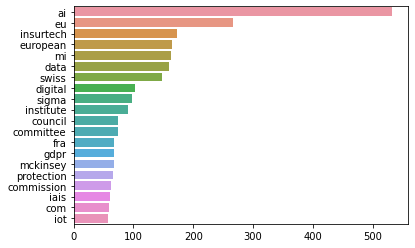

In [ ]:
import seaborn as sns


x, y= [], []
for word,count in commonWords[:20]:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [ ]:
# most frequest ORG entities
entities=[]
for doc in fullDocs.NLP:
    # all entities
    for ent in doc.ents:
        #print(ent.text)
        if ent.label_ == 'ORG':
            if ent.text not in STOP_WORDS:
                entities += [ent.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
print(commonEntities)

[('eu', 205), ('insurtech', 76), ('iais executive committee', 36), ('oecd', 27), ('mckinsey', 26), ('fra', 25), ('gdpr', 22), ('digital', 21), ('ec', 19), ('fca', 17), ('luxembourg publications office', 13), ('regtech', 13), ('european commission', 11), ('dlt', 11), ('allianz', 10), ('alibaba', 10), ('accenture', 9), ('q4', 9), ('rpa', 9), ('cb', 9), ('capgemini world', 8), ('adobe', 8), ('facebook', 8), ('coe', 8), ('amazon', 7), ('google', 7), ('cdo', 7), ('swiss sigma', 7), ('aviva', 7), ('bima', 6), ('european union', 6), ('echr', 6), ('european council', 6), ('mvp', 6), ('mi', 6), ('roi', 6), ('g20', 5), ('fintech', 5), ('bafin', 5), ('cltv', 5)]


<AxesSubplot:>

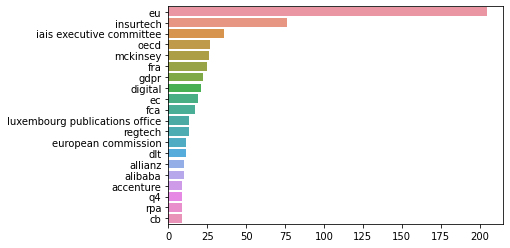

In [ ]:
import seaborn as sns


x, y= [], []
for word,count in commonEntities[:20]:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [ ]:
# most frequest PERSON entities
entities=[]
for doc in fullDocs.NLP:
    # all entities
    for ent in doc.ents:
        #print(ent.text)
        if ent.label_ == 'PERSON':
            if ent.text not in STOP_WORDS:
                entities += [ent.text]
entityFreq = Counter(entities)
commonEntities = entityFreq.most_common(40)
print(commonEntities)

[('fra', 10), ('leslie willcocks', 10), ('dpia', 8), ('bima', 6), ('tanguy catlin', 6), ('andrew brem', 6), ('emr ehr', 5), ('christopher geczy', 4), ('eurobarometer', 4), ('bafin', 4), ('holger wilms', 4), ('sartor giovanni', 3), ('christopher morrison', 3), ('johannes tobias lorenz', 3), ('bjorn munstermann', 3), ('tobias lorenz', 3), ('scott simony', 3), ('christopher geczy phd', 2), ('tina rosenberg', 2), ('com bima', 2), ('wessels', 2), ('hadi kharrazi', 2), ("harold lehmann casey overby taylor '", 2), ('gliklich leavy', 2), ('volker und markus schecke', 2), ('karntner landesregierung', 2), ('barak', 2), ('lukasz bojarski', 2), ('voor immigratie', 2), ('alessandro mantelero', 2), ('wachter mittelstatt b russel', 2), ('robo', 2), ('evia', 2), ('j sheth et al', 2), ('klinc', 2), ('sandeep bakshi', 2), ('matthew donaldson', 2), ('ido segev', 2), ('mendel', 2), ('nauto', 2)]


<AxesSubplot:>

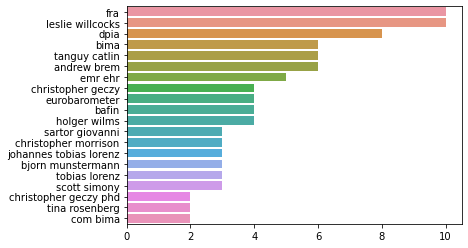

In [ ]:
import seaborn as sns


x, y= [], []
for word,count in commonEntities[:20]:
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)